
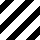
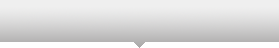
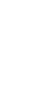
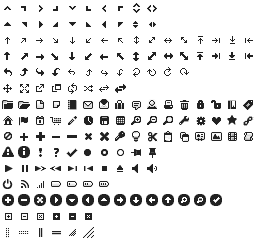
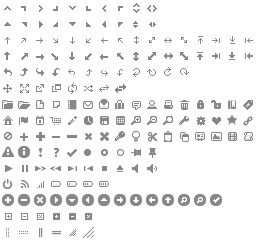
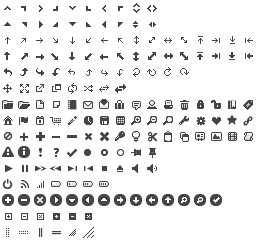
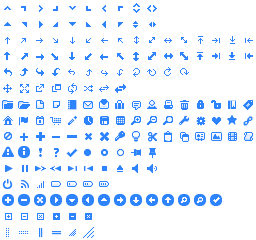
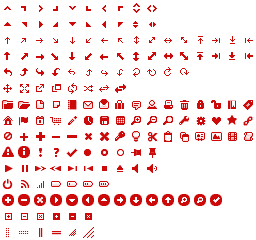
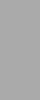
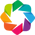
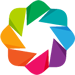
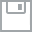
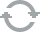
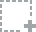
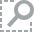
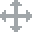
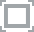
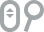

In [227]:
%matplotlib inline
# data manipulation and modeling
import numpy as np
import pandas as pd
import statsmodels.api as sm

# graphix
import matplotlib.pyplot as plt
import prettyplotlib as pplt
import seaborn as sns
import statsmodels.graphics.tsaplots as tsaplots

from bokeh.plotting import figure,gridplot,show,output_notebook
from bokeh.models import Range1d
output_notebook()

# utility
import os

# notebook parameters
pd.set_option('display.max_columns', 40) # number of columns in training set
plt.rcParams['figure.figsize'] = (25.0, 25.0)

In [2]:
training_data = pd.read_csv("TrainingSet.csv", index_col=0)
submission_labels = pd.read_csv("SubmissionRows.csv", index_col=0)

In [3]:
training_data.head(100)

1972 [YR1972]  1973 [YR1973]  1974 [YR1974]  1975 [YR1975]  \
0              NaN            NaN            NaN            NaN   
1              NaN            NaN            NaN            NaN   
2              NaN            NaN            NaN            NaN   
4              NaN            NaN            NaN            NaN   
5              NaN            NaN            NaN            NaN   
6              NaN            NaN            NaN            NaN   
8              NaN            NaN            NaN            NaN   
9              NaN            NaN            NaN            NaN   
10             NaN            NaN            NaN            NaN   
11             NaN            NaN            NaN            NaN   
12             NaN            NaN            NaN            NaN   
13             NaN            NaN            NaN            NaN   
16             NaN            NaN   2.670070e-01            NaN   
17             NaN            NaN   8.500150e+00            NaN   
18             NaN            NaN   4.402852e+01            NaN   
20             NaN            NaN            NaN            NaN   
21             NaN            NaN            NaN            NaN   
23             NaN            NaN            NaN            NaN   
24             NaN            NaN            NaN            NaN   
29    1.383995e-01   1.455553e-01   1.511521e-01   1.690770e-01   
30    2.257446e+06   2.577942e+06   3.328705e+06   4.087907e+06   
31             NaN            NaN            NaN            NaN   
32             NaN            NaN            NaN            NaN   
33    1.029650e+00   1.302140e+00   1.516893e+00   1.153010e+00   
34    1.679471e+07   2.306232e+07   3.340536e+07   2.787722e+07   
35    1.369047e+00   1.498578e+00   2.999907e+00   2.846491e+00   
36    2.233065e+07   2.654146e+07   6.606462e+07   6.882184e+07   
38    0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   
39    0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00   
40    3.596662e+00   3.687096e+00   5.196704e+00   5.700156e+00   
..             ...            ...            ...            ...   
89             NaN            NaN            NaN            NaN   
90             NaN            NaN            NaN            NaN   
91             NaN            NaN            NaN            NaN   
92             NaN            NaN            NaN            NaN   
93             NaN            NaN            NaN            NaN   
94             NaN            NaN            NaN            NaN   
95             NaN            NaN            NaN            NaN   
96             NaN            NaN            NaN            NaN   
97             NaN            NaN            NaN            NaN   
98             NaN            NaN            NaN            NaN   
99    3.270000e+02            NaN            NaN            NaN   
102            NaN            NaN            NaN            NaN   
104            NaN            NaN            NaN            NaN   
109   5.280000e+01   5.263200e+01   5.246300e+01   5.229800e+01   
110            NaN            NaN            NaN            NaN   
115   1.835376e+01   1.818398e+01   1.659227e+01   1.699455e+01   
116   1.317800e+10   1.418350e+10   1.609450e+10   1.809920e+10   
117   1.393740e+01   7.630141e+00   1.347340e+01   1.245581e+01   
118   3.602481e+00   2.496938e+00   1.775350e+00   1.851251e+00   
120            NaN            NaN            NaN            NaN   
121            NaN            NaN            NaN            NaN   
122            NaN            NaN            NaN            NaN   
123            NaN            NaN            NaN            NaN   
124   1.532806e+03   1.639149e+03   1.917841e+03   2.126860e+03   
125   1.316349e-01   1.369798e-01   1.562576e-01   1.694467e-01   
128   1.961722e+01   2.035794e+01   2.084130e+01   2.241379e+01   
129   3.006940e+02   3.336970e+02   3.997030e+02   4.767100e+02   
130   4.090909e+01   4.295302e+01   4.015296e+01   4

In [4]:
submission_labels.head()

2008 [YR2008]  2012 [YR2012]
559             NaN            NaN
618             NaN            NaN
753             NaN            NaN
1030            NaN            NaN
1896            NaN            NaN

Submission labels are simpler. First observation is we want to predict 2008 and 2012 (and not the years in between). Second observation is that the index values indentify specific rows in the training set. E.g., we want to predict the row in the training set that has the ID 559. Just to look that up:

In [5]:
training_data.loc[559]

1972 [YR1972]                                    NaN
1973 [YR1973]                                    NaN
1974 [YR1974]                                    NaN
1975 [YR1975]                                    NaN
1976 [YR1976]                                    NaN
1977 [YR1977]                                    NaN
1978 [YR1978]                                    NaN
1979 [YR1979]                                    NaN
1980 [YR1980]                                    NaN
1981 [YR1981]                                    NaN
1982 [YR1982]                                    NaN
1983 [YR1983]                                    NaN
1984 [YR1984]                                    NaN
1985 [YR1985]                                    NaN
1986 [YR1986]                                    NaN
1987 [YR1987]                                    NaN
1988 [YR1988]                                    NaN
1989 [YR1989]                                    NaN
1990 [YR1990]                                 

make it easier to grab any column that we want.

In [6]:
def generate_year_list(start, stop=None):
    """ 
    make a list of column names for specific years
    in the format they appear in the data frame start/stop inclusive
    """

    if isinstance(start, list):
        data_range = start
    elif stop:
        data_range = range(start, stop+1)
    else:
        data_range = [start]
    
    yrs = []
    
    for yr in data_range:
        yrs.append("{0} [YR{0}]".format(yr))
        
    return yrs

# ========== TEST CASES =======
# one year
print generate_year_list(2008)

# start and stop (inclusive)
print generate_year_list(1985, 1990)

# custom year list
print generate_year_list([1985, 1990])

['2008 [YR2008]']
['1985 [YR1985]', '1986 [YR1986]', '1987 [YR1987]', '1988 [YR1988]', '1989 [YR1989]', '1990 [YR1990]']
['1985 [YR1985]', '1990 [YR1990]']


In [7]:
prediction_rows = training_data.loc[submission_labels.index]

In [8]:
#prediction_rows

In [9]:
prediction_rows = prediction_rows[generate_year_list(1972, 2007)]
prediction_rows.head()

1972 [YR1972]  1973 [YR1973]  1974 [YR1974]  1975 [YR1975]  \
559             NaN            NaN            NaN            NaN   
618             NaN            NaN            NaN            NaN   
753           0.296         0.2909         0.2852         0.2798   
1030            NaN            NaN            NaN            NaN   
1896            NaN            NaN            NaN            NaN   

      1976 [YR1976]  1977 [YR1977]  1978 [YR1978]  1979 [YR1979]  \
559             NaN            NaN            NaN            NaN   
618             NaN            NaN            NaN            NaN   
753          0.2742         0.2683         0.2624         0.2565   
1030            NaN            NaN            NaN            NaN   
1896            NaN            NaN            NaN            NaN   

      1980 [YR1980]  1981 [YR1981]  1982 [YR1982]  1983 [YR1983]  \
559             NaN            NaN            NaN            NaN   
618             NaN            NaN            NaN            NaN   
753          0.2503         0.2439         0.2374         0.2304   
1030            NaN            NaN            NaN            NaN   
1896            NaN            NaN            NaN            NaN   

      1984 [YR1984]  1985 [YR1985]  1986 [YR1986]  1987 [YR1987]  \
559             NaN            NaN            NaN            NaN   
618             NaN            NaN            NaN            NaN   
753          0.2229         0.2151         0.2071         0.1993   
1030            NaN            NaN            NaN            NaN   
1896            NaN            NaN            NaN            NaN   

      1988 [YR1988]  1989 [YR1989]  1990 [YR1990]  1991 [YR1991]  \
559             NaN            NaN            NaN         0.0480   
618             NaN            NaN         0.0000            NaN   
753          0.1914         0.1836         0.1762         0.1693   
1030            NaN            NaN         0.0010         0.0010   
1896            NaN            NaN            NaN            NaN   

      1992 [YR1992]  1993 [YR1993]  1994 [YR1994]  1995 [YR1995]  \
559          0.0490         0.0490         0.0490         0.0490   
618             NaN            NaN            NaN            NaN   
753          0.1627         0.1571         0.1521         0.1479   
1030         0.0010         0.0010         0.0010         0.0010   
1896            NaN            NaN         0.9640         0.9640   

      1996 [YR1996]  1997 [YR1997]  1998 [YR1998]  1999 [YR1999]  \
559          0.0840         0.1180         0.1520         0.1870   
618             NaN            NaN            NaN            NaN   
753          0.1446         0.1417         0.1391         0.1366   
1030         0.0010         0.0010         0.0010         0.0010   
1896         0.9650         0.9650         0.9650         0.9650   

      2000 [YR2000]  2001 [YR2001]  2002 [YR2002]  2003 [YR2003]  \
559          0.2210       0.256000       0.291000       0.325000   
618             NaN       0.000047       0.000046       0.000879   
753          0.1339       0.131000       0.127700       0.124400   
1030         0.0010       0.001000       0.001000       0.001000   
1896         0.9650       0.964000       0.964000       0.963000   

      2004 [YR2004]  2005 [YR2005]  2006 [YR2006]  2007 [YR2007]  
559        0.360000       0.395000       0.430000         0.4650  
618        0.001058       0.012241       0.021071         0.0190  
753        0.121000       0.117700       0.114500         0.1115  
1030       0.001000       0.001000       0.001000         0.0010  
1896       0.963000       0.962000       0.962000         0.9610

In [10]:
#prediction_rows.info()

In [12]:
# p1 = figure(title='Title',plot_width=800, plot_height=800)
# p1.line(generate_year_list(2000, 2007),training_data.loc[737],alpha=.4, line_width=4)
# show(p1)
#country, descrip = training_data[["Country Name", "Series Name"]].loc[r]

#p2 = figure(title="{} - {}".format(country, descrip),plot_width=500, plot_height=200,title_text_font_size='6pt')
#p2 = figure(title="Try",plot_width=500, plot_height=200,title_text_font_size='6pt')
#p2.line(generate_year_list(1972, 2007),training_data[100:101,:],alpha=.4, line_width=2)
#p2.scatter(generate_year_list(2000, 2007),training_data.loc[737], alpha=0.4,)
#show(p2)

In [13]:
np.random.seed(10)
rand_rows = np.random.choice(prediction_rows.index.values, size=10)

def plot_rows(data, ids=None):
#     bmap = pplt.brewer2mpl.get_map('Set3','Qualitative', 10)
#     colors = bmap.mpl_colors
    
    if not None == ids:
        get_rows = lambda: enumerate(ids)
    else:
        get_rows = lambda: enumerate(data.index.values)
    
    for i,r in get_rows():
        time_data = data.loc[r]

        just_years = [y[:4] for y in data.columns]
        X = pd.DatetimeIndex(just_years)
        country, descrip = training_data[["Country Name", "Series Name"]].loc[r]

        p = figure(title="{} - {}".format(country, descrip),plot_width=500, plot_height=200,title_text_font_size='6pt')
        p.line(X, time_data,alpha=.4, line_width=2)
        p.scatter(X, time_data, alpha=0.4,)
        show(p)
plot_rows(prediction_rows, ids=rand_rows)


P:\Anaconda Python\Anaconda\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


P:\Anaconda Python\Anaconda\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


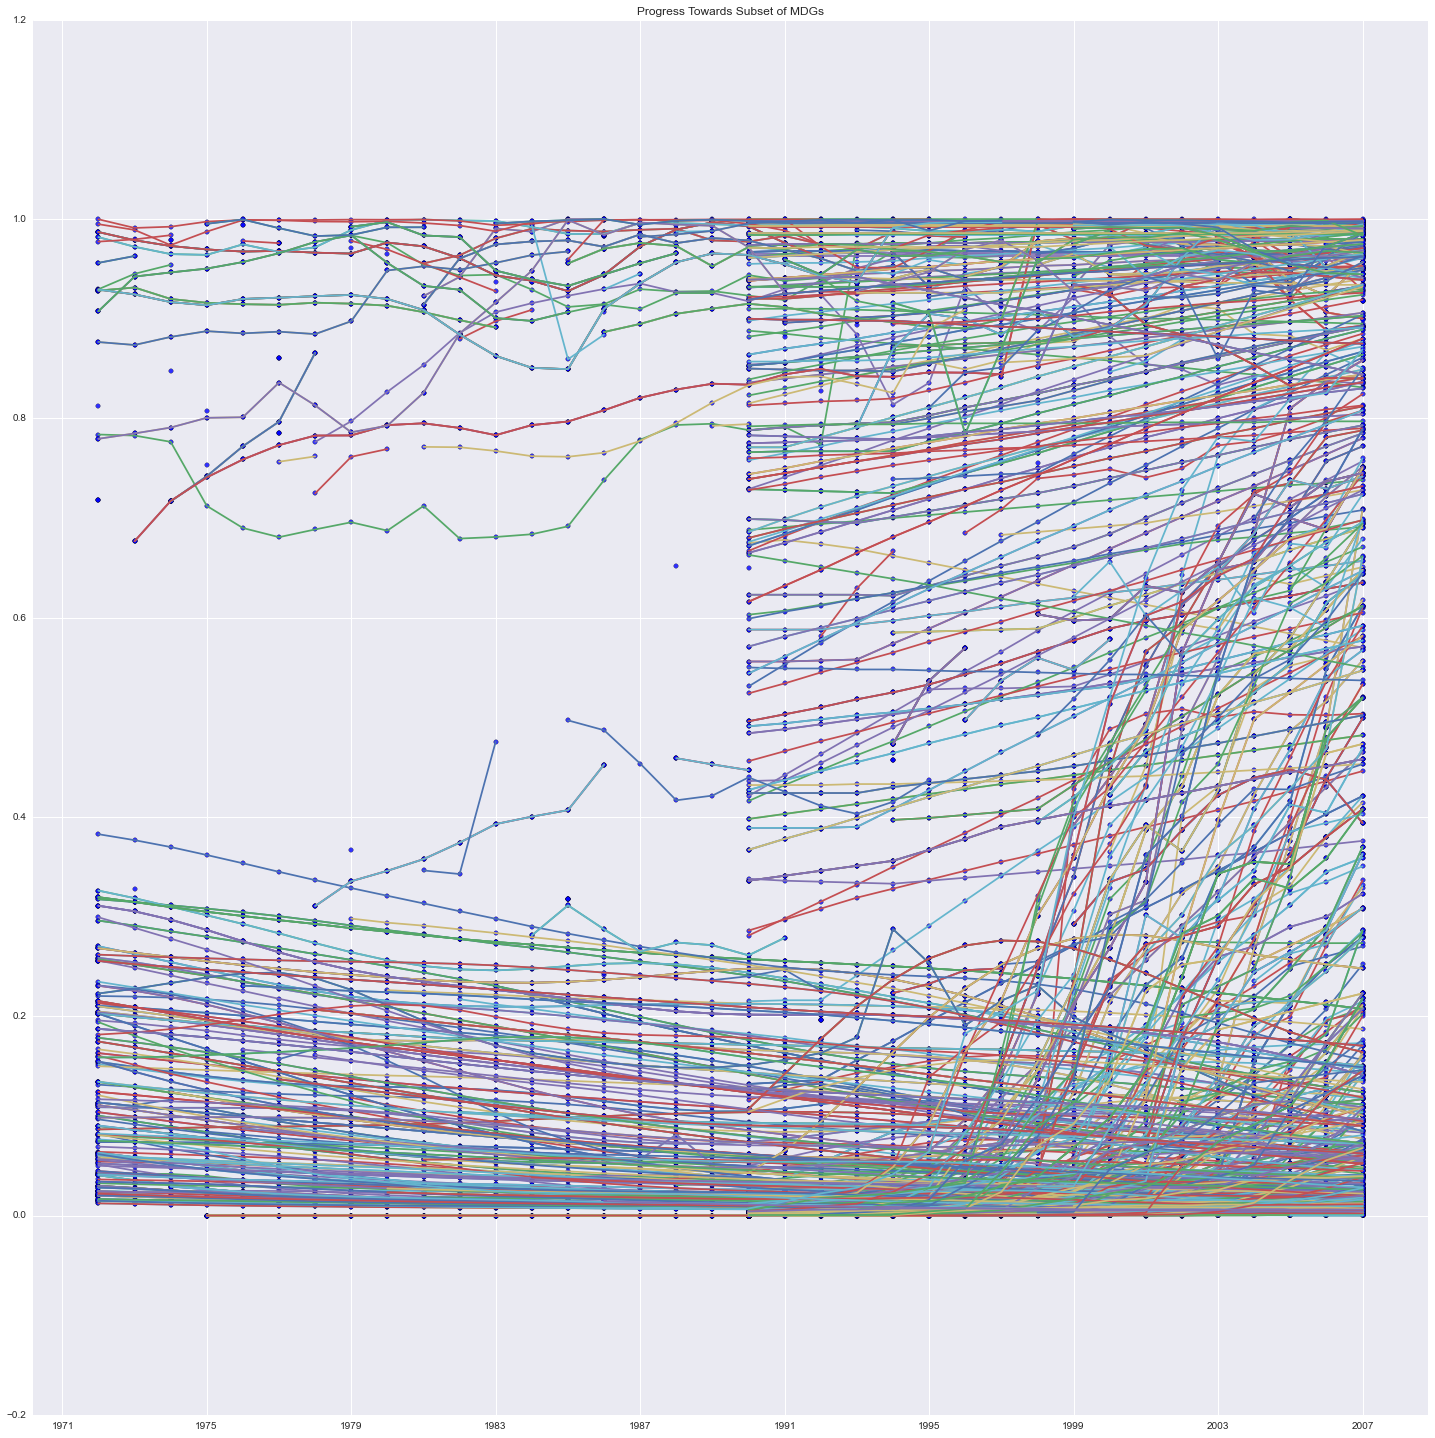

In [14]:
# grab a random sample of 10 of the timeseries
np.random.seed(100)
rand_rows = np.random.choice(prediction_rows.index.values, size=1000)

def plot_rows(data, ids=None, linestyle="-", legend=True):
    # get some colors for the lines
    bmap = pplt.brewer2mpl.get_map('Set3','Qualitative', 10, True)
    #colors = bmap.mpl_colors
    
    if not None == ids:
        get_rows = lambda: enumerate(ids)
    else:
        get_rows = lambda: enumerate(data.index.values)
    
    for i, r in get_rows():
        # get the time series values
        time_data = data.loc[r]

        # create an x axis to plot along
        just_years = [y[:4] for y in data.columns]
        X = pd.DatetimeIndex(just_years)

        # get time series info for labeling
        country, descrip = training_data[["Country Name", "Series Name"]].loc[r]

        # plot the series
        plt.plot(X, time_data, 
                 label="{} - {}".format(country, descrip), ls=linestyle)
        plt.scatter(X, time_data, alpha=0.8)

#     if legend:
#         plt.legend(loc=0)
    plt.title("Progress Towards Subset of MDGs")

plot_rows(prediction_rows, ids=rand_rows)
plt.show()

In [22]:
country_data = training_data[training_data["Country Name"] == 'India']
country_values = country_data[generate_year_list(1972, 2007)].values

In [66]:
# country_data

In [64]:
# country_values

In [73]:
#country_data.info()

In [232]:
countrydata = training_data.groupby("Country Name")

In [233]:
india = countrydata.get_group("India")
india

1972 [YR1972]  1973 [YR1973]  1974 [YR1974]  1975 [YR1975]  \
114990            NaN            NaN            NaN            NaN   
114991            NaN            NaN            NaN            NaN   
114992            NaN            NaN            NaN            NaN   
114993            NaN            NaN            NaN            NaN   
114994            NaN            NaN            NaN            NaN   
114995            NaN            NaN            NaN            NaN   
114996            NaN            NaN            NaN            NaN   
114998            NaN            NaN            NaN            NaN   
114999            NaN            NaN            NaN            NaN   
115000            NaN            NaN            NaN            NaN   
115001  -6.697895e-01   2.313600e+00  -1.531138e+00   6.592208e+00   
115002   1.396280e+11   1.428590e+11   1.406710e+11   1.499450e+11   
115003   6.563329e+10   7.828323e+10   9.029951e+10   8.772904e+10   
115004  -2.892019e+00   7.264818e-03  -3.767668e+00   4.154560e+00   
115005   2.404070e+02   2.404245e+02   2.313661e+02   2.409783e+02   
115006   1.130052e+02   1.317471e+02   1.485183e+02   1.409908e+02   
115007            NaN            NaN            NaN   7.396319e+00   
115008            NaN            NaN            NaN   7.389280e+09   
115009            NaN            NaN            NaN            NaN   
115010            NaN            NaN            NaN            NaN   
115011   4.436005e-01   4.074197e-01   3.990409e-01   4.852030e-01   
115012   3.208382e+08   3.528321e+08   4.026587e+08   4.847412e+08   
115013   7.216497e+00   6.914325e+00   7.479669e+00   8.051765e+00   
115014   5.219399e+09   5.987917e+09   7.547481e+09   8.044102e+09   
115015   2.410000e+00   2.418340e+00   2.561091e+00   2.209960e+00   
115016   1.743055e+09   2.094322e+09   2.584310e+09   2.207857e+09   
115017   2.103407e-01   2.453361e-01   6.697881e-01   1.119286e+00   
115018   1.521309e+08   2.124651e+08   6.758606e+08   1.118221e+09   
115019            NaN            NaN            NaN   1.785896e+01   
115020   1.366612e-01   1.174164e-01   1.478037e-01   2.041325e-01   
...               ...            ...            ...            ...   
116278            NaN            NaN            NaN            NaN   
116279            NaN            NaN            NaN            NaN   
116280            NaN            NaN            NaN            NaN   
116281            NaN            NaN            NaN            NaN   
116282            NaN            NaN            NaN            NaN   
116283            NaN            NaN            NaN            NaN   
116284            NaN            NaN            NaN            NaN   
116285            NaN            NaN            NaN            NaN   
116286            NaN            NaN            NaN            NaN   
116287   1.184179e+08   1.230170e+08   1.277875e+08   1.327346e+08   
116288   2.038880e+01   2.070320e+01   2.101760e+01   2.133200e+01   
116289   3.816655e+00   3.810233e+00   3.804689e+00   3.798258e+00   
116290   0.000000e+00   7.479700e+07   6.085150e+08   8.175230e+08   
116292            NaN            NaN            NaN            NaN   
116294            NaN            NaN            NaN            NaN   
116295            NaN            NaN            NaN            NaN   
116296            NaN            NaN            NaN            NaN   
116297            NaN            NaN            NaN            NaN   
116298            NaN            NaN            NaN            NaN   
116299            NaN            NaN            NaN            NaN   
116300            NaN            NaN            NaN            NaN   
116301            NaN            NaN            NaN            NaN   
116310            NaN            NaN            NaN            NaN   
116311   6.458208e+00   7.518547e+00   9.666839e+00   1.004536e+01   
116313            NaN            NaN            NaN            NaN   
116314            

In [189]:
india_values = india[generate_year_list(1972, 2007)].values

In [116]:
#india[generate_year_list(1972, 2007)]

In [190]:
i2_notnull = india[india.columns[:36]].fillna(method = 'bfill', axis = 1)
i2_notnull

1972 [YR1972]  1973 [YR1973]  1974 [YR1974]  1975 [YR1975]  \
114990   1.072211e+01   1.072211e+01   1.072211e+01   1.072211e+01   
114991   3.998927e+01   3.998927e+01   3.998927e+01   3.998927e+01   
114992   2.840343e+01   2.840343e+01   2.840343e+01   2.840343e+01   
114993   3.995493e+00   3.995493e+00   3.995493e+00   3.995493e+00   
114994   1.466854e+01   1.466854e+01   1.466854e+01   1.466854e+01   
114995   1.560154e+01   1.560154e+01   1.560154e+01   1.560154e+01   
114996   6.860000e+01   6.860000e+01   6.860000e+01   6.860000e+01   
114998   7.824938e-01   7.824938e-01   7.824938e-01   7.824938e-01   
114999   6.611141e+01   6.611141e+01   6.611141e+01   6.611141e+01   
115000   8.952264e+01   8.952264e+01   8.952264e+01   8.952264e+01   
115001  -6.697895e-01   2.313600e+00  -1.531138e+00   6.592208e+00   
115002   1.396280e+11   1.428590e+11   1.406710e+11   1.499450e+11   
115003   6.563329e+10   7.828323e+10   9.029951e+10   8.772904e+10   
115004  -2.892019e+00   7.264818e-03  -3.767668e+00   4.154560e+00   
115005   2.404070e+02   2.404245e+02   2.313661e+02   2.409783e+02   
115006   1.130052e+02   1.317471e+02   1.485183e+02   1.409908e+02   
115007   7.396319e+00   7.396319e+00   7.396319e+00   7.396319e+00   
115008   7.389280e+09   7.389280e+09   7.389280e+09   7.389280e+09   
115009   1.046534e+01   1.046534e+01   1.046534e+01   1.046534e+01   
115010   3.374069e+10   3.374069e+10   3.374069e+10   3.374069e+10   
115011   4.436005e-01   4.074197e-01   3.990409e-01   4.852030e-01   
115012   3.208382e+08   3.528321e+08   4.026587e+08   4.847412e+08   
115013   7.216497e+00   6.914325e+00   7.479669e+00   8.051765e+00   
115014   5.219399e+09   5.987917e+09   7.547481e+09   8.044102e+09   
115015   2.410000e+00   2.418340e+00   2.561091e+00   2.209960e+00   
115016   1.743055e+09   2.094322e+09   2.584310e+09   2.207857e+09   
115017   2.103407e-01   2.453361e-01   6.697881e-01   1.119286e+00   
115018   1.521309e+08   2.124651e+08   6.758606e+08   1.118221e+09   
115019   1.785896e+01   1.785896e+01   1.785896e+01   1.785896e+01   
115020   1.366612e-01   1.174164e-01   1.478037e-01   2.041325e-01   
...               ...            ...            ...            ...   
116278   4.100000e+00   4.100000e+00   4.100000e+00   4.100000e+00   
116279   3.700000e+00   3.700000e+00   3.700000e+00   3.700000e+00   
116280   8.900000e+00   8.900000e+00   8.900000e+00   8.900000e+00   
116281   8.000000e+00   8.000000e+00   8.000000e+00   8.000000e+00   
116282   9.000000e+00   9.000000e+00   9.000000e+00   9.000000e+00   
116283   8.300000e+00   8.300000e+00   8.300000e+00   8.300000e+00   
116284   9.000000e+00   9.000000e+00   9.000000e+00   9.000000e+00   
116285   8.200000e+00   8.200000e+00   8.200000e+00   8.200000e+00   
116286   1.650000e+01   1.650000e+01   1.650000e+01   1.650000e+01   
116287   1.184179e+08   1.230170e+08   1.277875e+08   1.327346e+08   
116288   2.038880e+01   2.070320e+01   2.101760e+01   2.133200e+01   
116289   3.816655e+00   3.810233e+00   3.804689e+00   3.798258e+00   
116290   0.000000e+00   7.479700e+07   6.085150e+08   8.175230e+08   
116292   8.140000e+00   8.140000e+00   8.140000e+00   8.140000e+00   
116294   1.500000e+01   1.500000e+01   1.500000e+01   1.500000e+01   
116295   9.110000e+01   9.110000e+01   9.110000e+01   9.110000e+01   
116296   7.980000e+01   7.980000e+01   7.980000e+01   7.980000e+01   
116297   8.310000e+01   8.310000e+01   8.310000e+01   8.310000e+01   
116298   8.200000e+00   8.200000e+00   8.200000e+00   8.200000e+00   
116299   1.500000e+01   1.500000e+01   1.500000e+01   1.500000e+01   
116300   1.780000e+01   1.780000e+01   1.780000e+01   1.780000e+01   
116301   2.600000e+00   2.600000e+00   2.600000e+00   2.600000e+00   
116310   5.020092e-01   5.020092e-01   5.020092e-01   5.020092e-01   
116311   6.458208e+00   7.518547e+00   9.666839e+00   1.004536e+01   
116313   3.030000e+01   3.030000e+01   3.030000e+01   3.030000e+01   
116314   2.040000e

In [191]:
i2_notnull=i2_notnull[i2_notnull.columns[:36]].fillna(method = 'ffill', axis = 1)
i2_notnull

1972 [YR1972]  1973 [YR1973]  1974 [YR1974]  1975 [YR1975]  \
114990   1.072211e+01   1.072211e+01   1.072211e+01   1.072211e+01   
114991   3.998927e+01   3.998927e+01   3.998927e+01   3.998927e+01   
114992   2.840343e+01   2.840343e+01   2.840343e+01   2.840343e+01   
114993   3.995493e+00   3.995493e+00   3.995493e+00   3.995493e+00   
114994   1.466854e+01   1.466854e+01   1.466854e+01   1.466854e+01   
114995   1.560154e+01   1.560154e+01   1.560154e+01   1.560154e+01   
114996   6.860000e+01   6.860000e+01   6.860000e+01   6.860000e+01   
114998   7.824938e-01   7.824938e-01   7.824938e-01   7.824938e-01   
114999   6.611141e+01   6.611141e+01   6.611141e+01   6.611141e+01   
115000   8.952264e+01   8.952264e+01   8.952264e+01   8.952264e+01   
115001  -6.697895e-01   2.313600e+00  -1.531138e+00   6.592208e+00   
115002   1.396280e+11   1.428590e+11   1.406710e+11   1.499450e+11   
115003   6.563329e+10   7.828323e+10   9.029951e+10   8.772904e+10   
115004  -2.892019e+00   7.264818e-03  -3.767668e+00   4.154560e+00   
115005   2.404070e+02   2.404245e+02   2.313661e+02   2.409783e+02   
115006   1.130052e+02   1.317471e+02   1.485183e+02   1.409908e+02   
115007   7.396319e+00   7.396319e+00   7.396319e+00   7.396319e+00   
115008   7.389280e+09   7.389280e+09   7.389280e+09   7.389280e+09   
115009   1.046534e+01   1.046534e+01   1.046534e+01   1.046534e+01   
115010   3.374069e+10   3.374069e+10   3.374069e+10   3.374069e+10   
115011   4.436005e-01   4.074197e-01   3.990409e-01   4.852030e-01   
115012   3.208382e+08   3.528321e+08   4.026587e+08   4.847412e+08   
115013   7.216497e+00   6.914325e+00   7.479669e+00   8.051765e+00   
115014   5.219399e+09   5.987917e+09   7.547481e+09   8.044102e+09   
115015   2.410000e+00   2.418340e+00   2.561091e+00   2.209960e+00   
115016   1.743055e+09   2.094322e+09   2.584310e+09   2.207857e+09   
115017   2.103407e-01   2.453361e-01   6.697881e-01   1.119286e+00   
115018   1.521309e+08   2.124651e+08   6.758606e+08   1.118221e+09   
115019   1.785896e+01   1.785896e+01   1.785896e+01   1.785896e+01   
115020   1.366612e-01   1.174164e-01   1.478037e-01   2.041325e-01   
...               ...            ...            ...            ...   
116278   4.100000e+00   4.100000e+00   4.100000e+00   4.100000e+00   
116279   3.700000e+00   3.700000e+00   3.700000e+00   3.700000e+00   
116280   8.900000e+00   8.900000e+00   8.900000e+00   8.900000e+00   
116281   8.000000e+00   8.000000e+00   8.000000e+00   8.000000e+00   
116282   9.000000e+00   9.000000e+00   9.000000e+00   9.000000e+00   
116283   8.300000e+00   8.300000e+00   8.300000e+00   8.300000e+00   
116284   9.000000e+00   9.000000e+00   9.000000e+00   9.000000e+00   
116285   8.200000e+00   8.200000e+00   8.200000e+00   8.200000e+00   
116286   1.650000e+01   1.650000e+01   1.650000e+01   1.650000e+01   
116287   1.184179e+08   1.230170e+08   1.277875e+08   1.327346e+08   
116288   2.038880e+01   2.070320e+01   2.101760e+01   2.133200e+01   
116289   3.816655e+00   3.810233e+00   3.804689e+00   3.798258e+00   
116290   0.000000e+00   7.479700e+07   6.085150e+08   8.175230e+08   
116292   8.140000e+00   8.140000e+00   8.140000e+00   8.140000e+00   
116294   1.500000e+01   1.500000e+01   1.500000e+01   1.500000e+01   
116295   9.110000e+01   9.110000e+01   9.110000e+01   9.110000e+01   
116296   7.980000e+01   7.980000e+01   7.980000e+01   7.980000e+01   
116297   8.310000e+01   8.310000e+01   8.310000e+01   8.310000e+01   
116298   8.200000e+00   8.200000e+00   8.200000e+00   8.200000e+00   
116299   1.500000e+01   1.500000e+01   1.500000e+01   1.500000e+01   
116300   1.780000e+01   1.780000e+01   1.780000e+01   1.780000e+01   
116301   2.600000e+00   2.600000e+00   2.600000e+00   2.600000e+00   
116310   5.020092e-01   5.020092e-01   5.020092e-01   5.020092e-01   
116311   6.458208e+00   7.518547e+00   9.666839e+00   1.004536e+01   
116313   3.030000e+01   3.030000e+01   3.030000e+01   3.030000e+01   
116314   2.040000e

In [176]:
# i3_notnull.describe()

In [177]:
# i3_notnull.info()

In [99]:
#i1 = india.loc[114990]
#i1

In [100]:
#i1_nn = i1.fillna(method = 'bfill')
#i1_nn

In [127]:
# i_notnull = india.fillna(method = 'bfill', axis = 1, inplace = Truw)
# i_notnull

In [ ]:
# normalized_data = StandardScaler().fit_transform(data.astype(float))

In [152]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [171]:
# figure(figsize = (10,7))
# ts = pd.Series(i3_notnull.loc[115001], index=pd.date_range(start = '1972', end = '2007'))
# ts = ts.cumsum()
# ts.plot()

In [178]:
countrydata = training_data.groupby("Country Name")

In [196]:
india1 = countrydata.get_group("India")

In [197]:
india1 = india1[india1.columns[:36]].fillna(method = 'bfill', axis = 1)
india1

1972 [YR1972]  1973 [YR1973]  1974 [YR1974]  1975 [YR1975]  \
114990   1.072211e+01   1.072211e+01   1.072211e+01   1.072211e+01   
114991   3.998927e+01   3.998927e+01   3.998927e+01   3.998927e+01   
114992   2.840343e+01   2.840343e+01   2.840343e+01   2.840343e+01   
114993   3.995493e+00   3.995493e+00   3.995493e+00   3.995493e+00   
114994   1.466854e+01   1.466854e+01   1.466854e+01   1.466854e+01   
114995   1.560154e+01   1.560154e+01   1.560154e+01   1.560154e+01   
114996   6.860000e+01   6.860000e+01   6.860000e+01   6.860000e+01   
114998   7.824938e-01   7.824938e-01   7.824938e-01   7.824938e-01   
114999   6.611141e+01   6.611141e+01   6.611141e+01   6.611141e+01   
115000   8.952264e+01   8.952264e+01   8.952264e+01   8.952264e+01   
115001  -6.697895e-01   2.313600e+00  -1.531138e+00   6.592208e+00   
115002   1.396280e+11   1.428590e+11   1.406710e+11   1.499450e+11   
115003   6.563329e+10   7.828323e+10   9.029951e+10   8.772904e+10   
115004  -2.892019e+00   7.264818e-03  -3.767668e+00   4.154560e+00   
115005   2.404070e+02   2.404245e+02   2.313661e+02   2.409783e+02   
115006   1.130052e+02   1.317471e+02   1.485183e+02   1.409908e+02   
115007   7.396319e+00   7.396319e+00   7.396319e+00   7.396319e+00   
115008   7.389280e+09   7.389280e+09   7.389280e+09   7.389280e+09   
115009   1.046534e+01   1.046534e+01   1.046534e+01   1.046534e+01   
115010   3.374069e+10   3.374069e+10   3.374069e+10   3.374069e+10   
115011   4.436005e-01   4.074197e-01   3.990409e-01   4.852030e-01   
115012   3.208382e+08   3.528321e+08   4.026587e+08   4.847412e+08   
115013   7.216497e+00   6.914325e+00   7.479669e+00   8.051765e+00   
115014   5.219399e+09   5.987917e+09   7.547481e+09   8.044102e+09   
115015   2.410000e+00   2.418340e+00   2.561091e+00   2.209960e+00   
115016   1.743055e+09   2.094322e+09   2.584310e+09   2.207857e+09   
115017   2.103407e-01   2.453361e-01   6.697881e-01   1.119286e+00   
115018   1.521309e+08   2.124651e+08   6.758606e+08   1.118221e+09   
115019   1.785896e+01   1.785896e+01   1.785896e+01   1.785896e+01   
115020   1.366612e-01   1.174164e-01   1.478037e-01   2.041325e-01   
...               ...            ...            ...            ...   
116278   4.100000e+00   4.100000e+00   4.100000e+00   4.100000e+00   
116279   3.700000e+00   3.700000e+00   3.700000e+00   3.700000e+00   
116280   8.900000e+00   8.900000e+00   8.900000e+00   8.900000e+00   
116281   8.000000e+00   8.000000e+00   8.000000e+00   8.000000e+00   
116282   9.000000e+00   9.000000e+00   9.000000e+00   9.000000e+00   
116283   8.300000e+00   8.300000e+00   8.300000e+00   8.300000e+00   
116284   9.000000e+00   9.000000e+00   9.000000e+00   9.000000e+00   
116285   8.200000e+00   8.200000e+00   8.200000e+00   8.200000e+00   
116286   1.650000e+01   1.650000e+01   1.650000e+01   1.650000e+01   
116287   1.184179e+08   1.230170e+08   1.277875e+08   1.327346e+08   
116288   2.038880e+01   2.070320e+01   2.101760e+01   2.133200e+01   
116289   3.816655e+00   3.810233e+00   3.804689e+00   3.798258e+00   
116290   0.000000e+00   7.479700e+07   6.085150e+08   8.175230e+08   
116292   8.140000e+00   8.140000e+00   8.140000e+00   8.140000e+00   
116294   1.500000e+01   1.500000e+01   1.500000e+01   1.500000e+01   
116295   9.110000e+01   9.110000e+01   9.110000e+01   9.110000e+01   
116296   7.980000e+01   7.980000e+01   7.980000e+01   7.980000e+01   
116297   8.310000e+01   8.310000e+01   8.310000e+01   8.310000e+01   
116298   8.200000e+00   8.200000e+00   8.200000e+00   8.200000e+00   
116299   1.500000e+01   1.500000e+01   1.500000e+01   1.500000e+01   
116300   1.780000e+01   1.780000e+01   1.780000e+01   1.780000e+01   
116301   2.600000e+00   2.600000e+00   2.600000e+00   2.600000e+00   
116310   5.020092e-01   5.020092e-01   5.020092e-01   5.020092e-01   
116311   6.458208e+00   7.518547e+00   9.666839e+00   1.004536e+01   
116313   3.030000e+01   3.030000e+01   3.030000e+01   3.030000e+01   
116314   2.040000e

In [198]:
india1 = india1[india1.columns[:36]].fillna(method = 'ffill', axis = 1)
india1

1972 [YR1972]  1973 [YR1973]  1974 [YR1974]  1975 [YR1975]  \
114990   1.072211e+01   1.072211e+01   1.072211e+01   1.072211e+01   
114991   3.998927e+01   3.998927e+01   3.998927e+01   3.998927e+01   
114992   2.840343e+01   2.840343e+01   2.840343e+01   2.840343e+01   
114993   3.995493e+00   3.995493e+00   3.995493e+00   3.995493e+00   
114994   1.466854e+01   1.466854e+01   1.466854e+01   1.466854e+01   
114995   1.560154e+01   1.560154e+01   1.560154e+01   1.560154e+01   
114996   6.860000e+01   6.860000e+01   6.860000e+01   6.860000e+01   
114998   7.824938e-01   7.824938e-01   7.824938e-01   7.824938e-01   
114999   6.611141e+01   6.611141e+01   6.611141e+01   6.611141e+01   
115000   8.952264e+01   8.952264e+01   8.952264e+01   8.952264e+01   
115001  -6.697895e-01   2.313600e+00  -1.531138e+00   6.592208e+00   
115002   1.396280e+11   1.428590e+11   1.406710e+11   1.499450e+11   
115003   6.563329e+10   7.828323e+10   9.029951e+10   8.772904e+10   
115004  -2.892019e+00   7.264818e-03  -3.767668e+00   4.154560e+00   
115005   2.404070e+02   2.404245e+02   2.313661e+02   2.409783e+02   
115006   1.130052e+02   1.317471e+02   1.485183e+02   1.409908e+02   
115007   7.396319e+00   7.396319e+00   7.396319e+00   7.396319e+00   
115008   7.389280e+09   7.389280e+09   7.389280e+09   7.389280e+09   
115009   1.046534e+01   1.046534e+01   1.046534e+01   1.046534e+01   
115010   3.374069e+10   3.374069e+10   3.374069e+10   3.374069e+10   
115011   4.436005e-01   4.074197e-01   3.990409e-01   4.852030e-01   
115012   3.208382e+08   3.528321e+08   4.026587e+08   4.847412e+08   
115013   7.216497e+00   6.914325e+00   7.479669e+00   8.051765e+00   
115014   5.219399e+09   5.987917e+09   7.547481e+09   8.044102e+09   
115015   2.410000e+00   2.418340e+00   2.561091e+00   2.209960e+00   
115016   1.743055e+09   2.094322e+09   2.584310e+09   2.207857e+09   
115017   2.103407e-01   2.453361e-01   6.697881e-01   1.119286e+00   
115018   1.521309e+08   2.124651e+08   6.758606e+08   1.118221e+09   
115019   1.785896e+01   1.785896e+01   1.785896e+01   1.785896e+01   
115020   1.366612e-01   1.174164e-01   1.478037e-01   2.041325e-01   
...               ...            ...            ...            ...   
116278   4.100000e+00   4.100000e+00   4.100000e+00   4.100000e+00   
116279   3.700000e+00   3.700000e+00   3.700000e+00   3.700000e+00   
116280   8.900000e+00   8.900000e+00   8.900000e+00   8.900000e+00   
116281   8.000000e+00   8.000000e+00   8.000000e+00   8.000000e+00   
116282   9.000000e+00   9.000000e+00   9.000000e+00   9.000000e+00   
116283   8.300000e+00   8.300000e+00   8.300000e+00   8.300000e+00   
116284   9.000000e+00   9.000000e+00   9.000000e+00   9.000000e+00   
116285   8.200000e+00   8.200000e+00   8.200000e+00   8.200000e+00   
116286   1.650000e+01   1.650000e+01   1.650000e+01   1.650000e+01   
116287   1.184179e+08   1.230170e+08   1.277875e+08   1.327346e+08   
116288   2.038880e+01   2.070320e+01   2.101760e+01   2.133200e+01   
116289   3.816655e+00   3.810233e+00   3.804689e+00   3.798258e+00   
116290   0.000000e+00   7.479700e+07   6.085150e+08   8.175230e+08   
116292   8.140000e+00   8.140000e+00   8.140000e+00   8.140000e+00   
116294   1.500000e+01   1.500000e+01   1.500000e+01   1.500000e+01   
116295   9.110000e+01   9.110000e+01   9.110000e+01   9.110000e+01   
116296   7.980000e+01   7.980000e+01   7.980000e+01   7.980000e+01   
116297   8.310000e+01   8.310000e+01   8.310000e+01   8.310000e+01   
116298   8.200000e+00   8.200000e+00   8.200000e+00   8.200000e+00   
116299   1.500000e+01   1.500000e+01   1.500000e+01   1.500000e+01   
116300   1.780000e+01   1.780000e+01   1.780000e+01   1.780000e+01   
116301   2.600000e+00   2.600000e+00   2.600000e+00   2.600000e+00   
116310   5.020092e-01   5.020092e-01   5.020092e-01   5.020092e-01   
116311   6.458208e+00   7.518547e+00   9.666839e+00   1.004536e+01   
116313   3.030000e+01   3.030000e+01   3.030000e+01   3.030000e+01   
116314   2.040000e

In [205]:
india2 = countrydata.get_group("India")

In [206]:
india2[india2.columns[:36]] = india2[india2.columns[:36]].fillna(method = 'bfill', axis = 1)
india2

1972 [YR1972]  1973 [YR1973]  1974 [YR1974]  1975 [YR1975]  \
114990   1.072211e+01   1.072211e+01   1.072211e+01   1.072211e+01   
114991   3.998927e+01   3.998927e+01   3.998927e+01   3.998927e+01   
114992   2.840343e+01   2.840343e+01   2.840343e+01   2.840343e+01   
114993   3.995493e+00   3.995493e+00   3.995493e+00   3.995493e+00   
114994   1.466854e+01   1.466854e+01   1.466854e+01   1.466854e+01   
114995   1.560154e+01   1.560154e+01   1.560154e+01   1.560154e+01   
114996   6.860000e+01   6.860000e+01   6.860000e+01   6.860000e+01   
114998   7.824938e-01   7.824938e-01   7.824938e-01   7.824938e-01   
114999   6.611141e+01   6.611141e+01   6.611141e+01   6.611141e+01   
115000   8.952264e+01   8.952264e+01   8.952264e+01   8.952264e+01   
115001  -6.697895e-01   2.313600e+00  -1.531138e+00   6.592208e+00   
115002   1.396280e+11   1.428590e+11   1.406710e+11   1.499450e+11   
115003   6.563329e+10   7.828323e+10   9.029951e+10   8.772904e+10   
115004  -2.892019e+00   7.264818e-03  -3.767668e+00   4.154560e+00   
115005   2.404070e+02   2.404245e+02   2.313661e+02   2.409783e+02   
115006   1.130052e+02   1.317471e+02   1.485183e+02   1.409908e+02   
115007   7.396319e+00   7.396319e+00   7.396319e+00   7.396319e+00   
115008   7.389280e+09   7.389280e+09   7.389280e+09   7.389280e+09   
115009   1.046534e+01   1.046534e+01   1.046534e+01   1.046534e+01   
115010   3.374069e+10   3.374069e+10   3.374069e+10   3.374069e+10   
115011   4.436005e-01   4.074197e-01   3.990409e-01   4.852030e-01   
115012   3.208382e+08   3.528321e+08   4.026587e+08   4.847412e+08   
115013   7.216497e+00   6.914325e+00   7.479669e+00   8.051765e+00   
115014   5.219399e+09   5.987917e+09   7.547481e+09   8.044102e+09   
115015   2.410000e+00   2.418340e+00   2.561091e+00   2.209960e+00   
115016   1.743055e+09   2.094322e+09   2.584310e+09   2.207857e+09   
115017   2.103407e-01   2.453361e-01   6.697881e-01   1.119286e+00   
115018   1.521309e+08   2.124651e+08   6.758606e+08   1.118221e+09   
115019   1.785896e+01   1.785896e+01   1.785896e+01   1.785896e+01   
115020   1.366612e-01   1.174164e-01   1.478037e-01   2.041325e-01   
...               ...            ...            ...            ...   
116278   4.100000e+00   4.100000e+00   4.100000e+00   4.100000e+00   
116279   3.700000e+00   3.700000e+00   3.700000e+00   3.700000e+00   
116280   8.900000e+00   8.900000e+00   8.900000e+00   8.900000e+00   
116281   8.000000e+00   8.000000e+00   8.000000e+00   8.000000e+00   
116282   9.000000e+00   9.000000e+00   9.000000e+00   9.000000e+00   
116283   8.300000e+00   8.300000e+00   8.300000e+00   8.300000e+00   
116284   9.000000e+00   9.000000e+00   9.000000e+00   9.000000e+00   
116285   8.200000e+00   8.200000e+00   8.200000e+00   8.200000e+00   
116286   1.650000e+01   1.650000e+01   1.650000e+01   1.650000e+01   
116287   1.184179e+08   1.230170e+08   1.277875e+08   1.327346e+08   
116288   2.038880e+01   2.070320e+01   2.101760e+01   2.133200e+01   
116289   3.816655e+00   3.810233e+00   3.804689e+00   3.798258e+00   
116290   0.000000e+00   7.479700e+07   6.085150e+08   8.175230e+08   
116292   8.140000e+00   8.140000e+00   8.140000e+00   8.140000e+00   
116294   1.500000e+01   1.500000e+01   1.500000e+01   1.500000e+01   
116295   9.110000e+01   9.110000e+01   9.110000e+01   9.110000e+01   
116296   7.980000e+01   7.980000e+01   7.980000e+01   7.980000e+01   
116297   8.310000e+01   8.310000e+01   8.310000e+01   8.310000e+01   
116298   8.200000e+00   8.200000e+00   8.200000e+00   8.200000e+00   
116299   1.500000e+01   1.500000e+01   1.500000e+01   1.500000e+01   
116300   1.780000e+01   1.780000e+01   1.780000e+01   1.780000e+01   
116301   2.600000e+00   2.600000e+00   2.600000e+00   2.600000e+00   
116310   5.020092e-01   5.020092e-01   5.020092e-01   5.020092e-01   
116311   6.458208e+00   7.518547e+00   9.666839e+00   1.004536e+01   
116313   3.030000e+01   3.030000e+01   3.030000e+01   3.030000e+01   
116314   2.040000e

In [207]:
india2[india2.columns[:36]] = india2[india2.columns[:36]].fillna(method = 'ffill', axis = 1)
india2

1972 [YR1972]  1973 [YR1973]  1974 [YR1974]  1975 [YR1975]  \
114990   1.072211e+01   1.072211e+01   1.072211e+01   1.072211e+01   
114991   3.998927e+01   3.998927e+01   3.998927e+01   3.998927e+01   
114992   2.840343e+01   2.840343e+01   2.840343e+01   2.840343e+01   
114993   3.995493e+00   3.995493e+00   3.995493e+00   3.995493e+00   
114994   1.466854e+01   1.466854e+01   1.466854e+01   1.466854e+01   
114995   1.560154e+01   1.560154e+01   1.560154e+01   1.560154e+01   
114996   6.860000e+01   6.860000e+01   6.860000e+01   6.860000e+01   
114998   7.824938e-01   7.824938e-01   7.824938e-01   7.824938e-01   
114999   6.611141e+01   6.611141e+01   6.611141e+01   6.611141e+01   
115000   8.952264e+01   8.952264e+01   8.952264e+01   8.952264e+01   
115001  -6.697895e-01   2.313600e+00  -1.531138e+00   6.592208e+00   
115002   1.396280e+11   1.428590e+11   1.406710e+11   1.499450e+11   
115003   6.563329e+10   7.828323e+10   9.029951e+10   8.772904e+10   
115004  -2.892019e+00   7.264818e-03  -3.767668e+00   4.154560e+00   
115005   2.404070e+02   2.404245e+02   2.313661e+02   2.409783e+02   
115006   1.130052e+02   1.317471e+02   1.485183e+02   1.409908e+02   
115007   7.396319e+00   7.396319e+00   7.396319e+00   7.396319e+00   
115008   7.389280e+09   7.389280e+09   7.389280e+09   7.389280e+09   
115009   1.046534e+01   1.046534e+01   1.046534e+01   1.046534e+01   
115010   3.374069e+10   3.374069e+10   3.374069e+10   3.374069e+10   
115011   4.436005e-01   4.074197e-01   3.990409e-01   4.852030e-01   
115012   3.208382e+08   3.528321e+08   4.026587e+08   4.847412e+08   
115013   7.216497e+00   6.914325e+00   7.479669e+00   8.051765e+00   
115014   5.219399e+09   5.987917e+09   7.547481e+09   8.044102e+09   
115015   2.410000e+00   2.418340e+00   2.561091e+00   2.209960e+00   
115016   1.743055e+09   2.094322e+09   2.584310e+09   2.207857e+09   
115017   2.103407e-01   2.453361e-01   6.697881e-01   1.119286e+00   
115018   1.521309e+08   2.124651e+08   6.758606e+08   1.118221e+09   
115019   1.785896e+01   1.785896e+01   1.785896e+01   1.785896e+01   
115020   1.366612e-01   1.174164e-01   1.478037e-01   2.041325e-01   
...               ...            ...            ...            ...   
116278   4.100000e+00   4.100000e+00   4.100000e+00   4.100000e+00   
116279   3.700000e+00   3.700000e+00   3.700000e+00   3.700000e+00   
116280   8.900000e+00   8.900000e+00   8.900000e+00   8.900000e+00   
116281   8.000000e+00   8.000000e+00   8.000000e+00   8.000000e+00   
116282   9.000000e+00   9.000000e+00   9.000000e+00   9.000000e+00   
116283   8.300000e+00   8.300000e+00   8.300000e+00   8.300000e+00   
116284   9.000000e+00   9.000000e+00   9.000000e+00   9.000000e+00   
116285   8.200000e+00   8.200000e+00   8.200000e+00   8.200000e+00   
116286   1.650000e+01   1.650000e+01   1.650000e+01   1.650000e+01   
116287   1.184179e+08   1.230170e+08   1.277875e+08   1.327346e+08   
116288   2.038880e+01   2.070320e+01   2.101760e+01   2.133200e+01   
116289   3.816655e+00   3.810233e+00   3.804689e+00   3.798258e+00   
116290   0.000000e+00   7.479700e+07   6.085150e+08   8.175230e+08   
116292   8.140000e+00   8.140000e+00   8.140000e+00   8.140000e+00   
116294   1.500000e+01   1.500000e+01   1.500000e+01   1.500000e+01   
116295   9.110000e+01   9.110000e+01   9.110000e+01   9.110000e+01   
116296   7.980000e+01   7.980000e+01   7.980000e+01   7.980000e+01   
116297   8.310000e+01   8.310000e+01   8.310000e+01   8.310000e+01   
116298   8.200000e+00   8.200000e+00   8.200000e+00   8.200000e+00   
116299   1.500000e+01   1.500000e+01   1.500000e+01   1.500000e+01   
116300   1.780000e+01   1.780000e+01   1.780000e+01   1.780000e+01   
116301   2.600000e+00   2.600000e+00   2.600000e+00   2.600000e+00   
116310   5.020092e-01   5.020092e-01   5.020092e-01   5.020092e-01   
116311   6.458208e+00   7.518547e+00   9.666839e+00   1.004536e+01   
116313   3.030000e+01   3.030000e+01   3.030000e+01   3.030000e+01   
116314   2.040000e

In [229]:
india2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1240 entries, 114990 to 116318
Data columns (total 39 columns):
1972 [YR1972]    1240 non-null float64
1973 [YR1973]    1240 non-null float64
1974 [YR1974]    1240 non-null float64
1975 [YR1975]    1240 non-null float64
1976 [YR1976]    1240 non-null float64
1977 [YR1977]    1240 non-null float64
1978 [YR1978]    1240 non-null float64
1979 [YR1979]    1240 non-null float64
1980 [YR1980]    1240 non-null float64
1981 [YR1981]    1240 non-null float64
1982 [YR1982]    1240 non-null float64
1983 [YR1983]    1240 non-null float64
1984 [YR1984]    1240 non-null float64
1985 [YR1985]    1240 non-null float64
1986 [YR1986]    1240 non-null float64
1987 [YR1987]    1240 non-null float64
1988 [YR1988]    1240 non-null float64
1989 [YR1989]    1240 non-null float64
1990 [YR1990]    1240 non-null float64
1991 [YR1991]    1240 non-null float64
1992 [YR1992]    1240 non-null float64
1993 [YR1993]    1240 non-null float64
1994 [YR1994]    1240 non-nu

In [214]:
indiar = india2.loc[india2.index]

In [216]:
indiar.index.values

array([114990, 114991, 114992, ..., 116316, 116317, 116318], dtype=int64)

In [224]:
indiar = indiar[generate_year_list(1972, 2007)]

P:\Anaconda Python\Anaconda\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


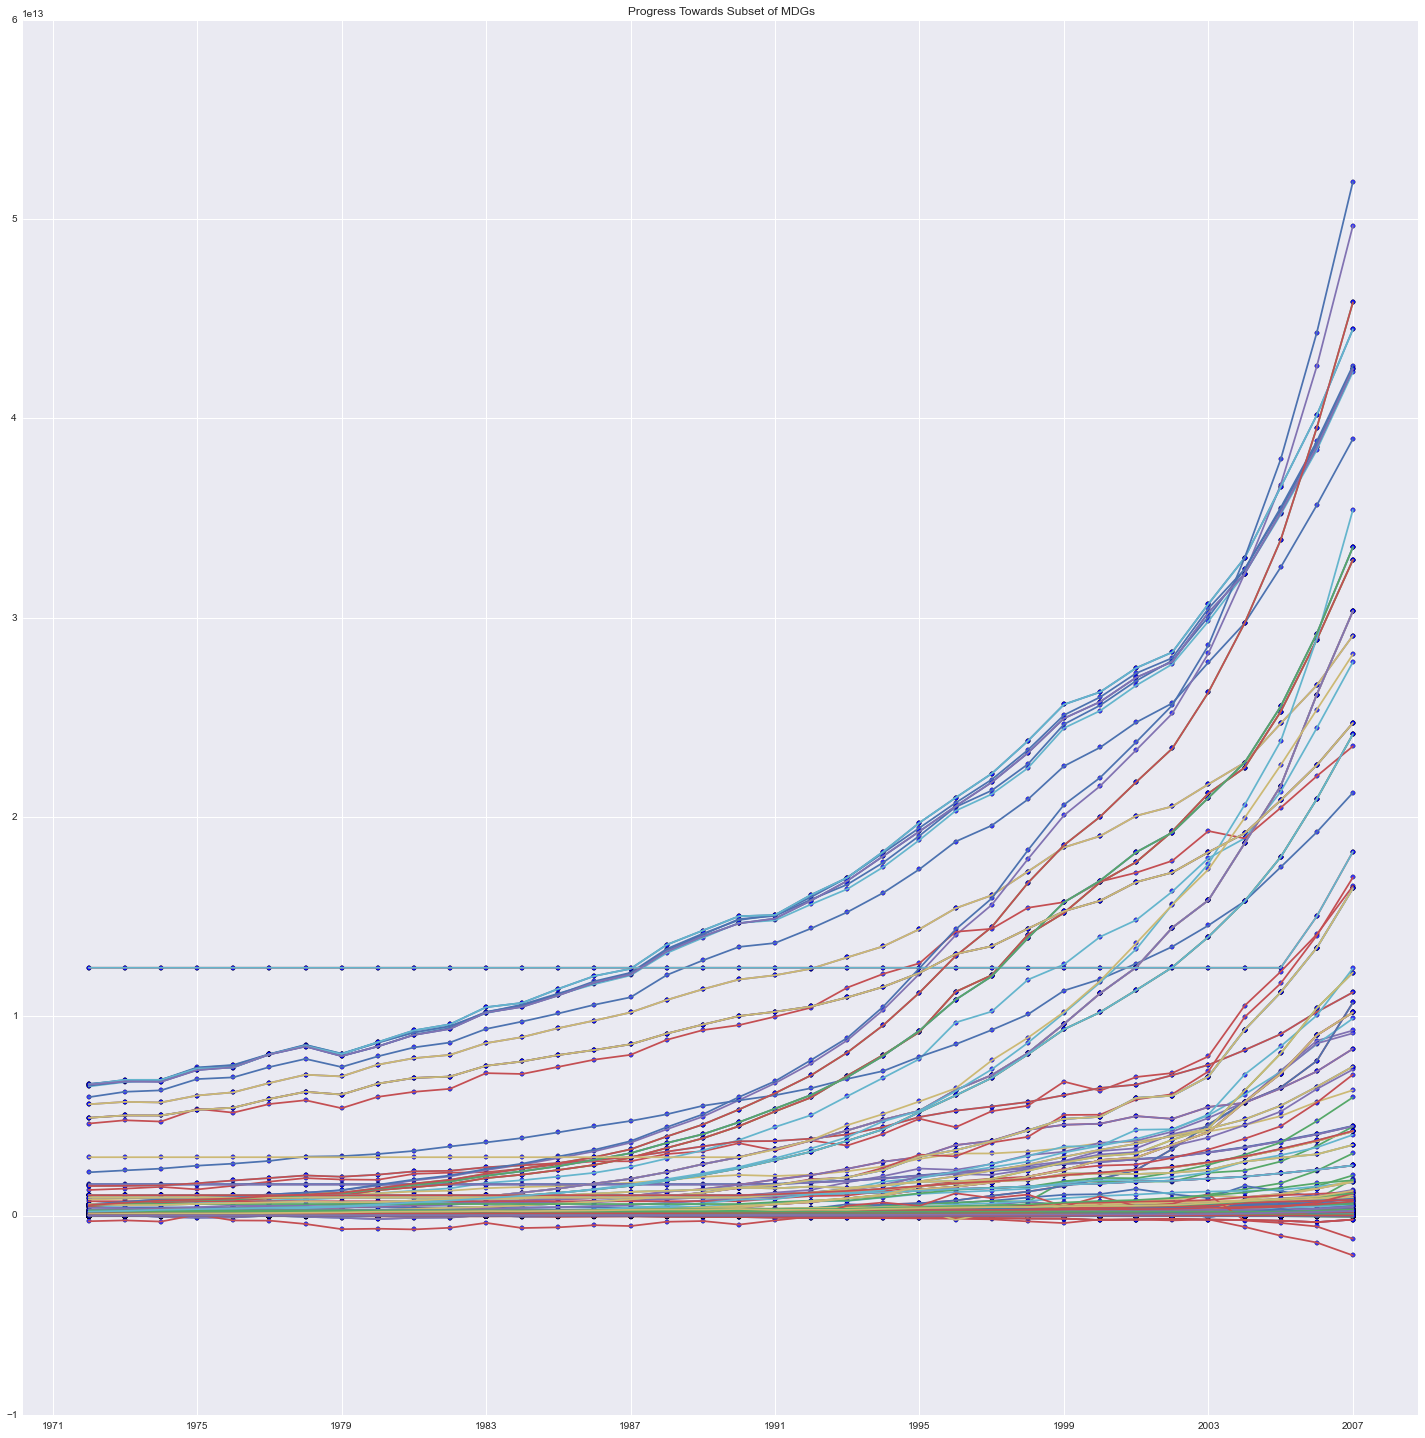

In [231]:
np.random.seed(100)
rand_rows = np.random.choice(indiar.index.values, size=1240)

def plot_rows(data, ids=None, linestyle="-", legend=True):
    # get some colors for the lines
    bmap = pplt.brewer2mpl.get_map('Set3','Qualitative', 10, True)
    #colors = bmap.mpl_colors
    
    if not None == ids:
        get_rows = lambda: enumerate(ids)
    else:
        get_rows = lambda: enumerate(data.index.values)
    
    for i, r in get_rows():
        # get the time series values
        time_data = data.loc[r]

        # create an x axis to plot along
        just_years = [y[:4] for y in data.columns]
        X = pd.DatetimeIndex(just_years)

        # get time series info for labeling
        country, descrip = india2[["Country Name", "Series Name"]].loc[r]

        # plot the series
        plt.plot(X, time_data, 
                 label="{} - {}".format(country, descrip), ls=linestyle)
        plt.scatter(X, time_data, alpha=0.8)

#     if legend:
#         plt.legend(loc=0)
    plt.title("Progress Towards Subset of MDGs")

plot_rows(indiar, ids=rand_rows)
plt.show()

In [ ]:
#with the null values

In [234]:
indianr = india.loc[india2.index]

In [235]:
indianr = indianr[generate_year_list(1972, 2007)]

P:\Anaconda Python\Anaconda\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


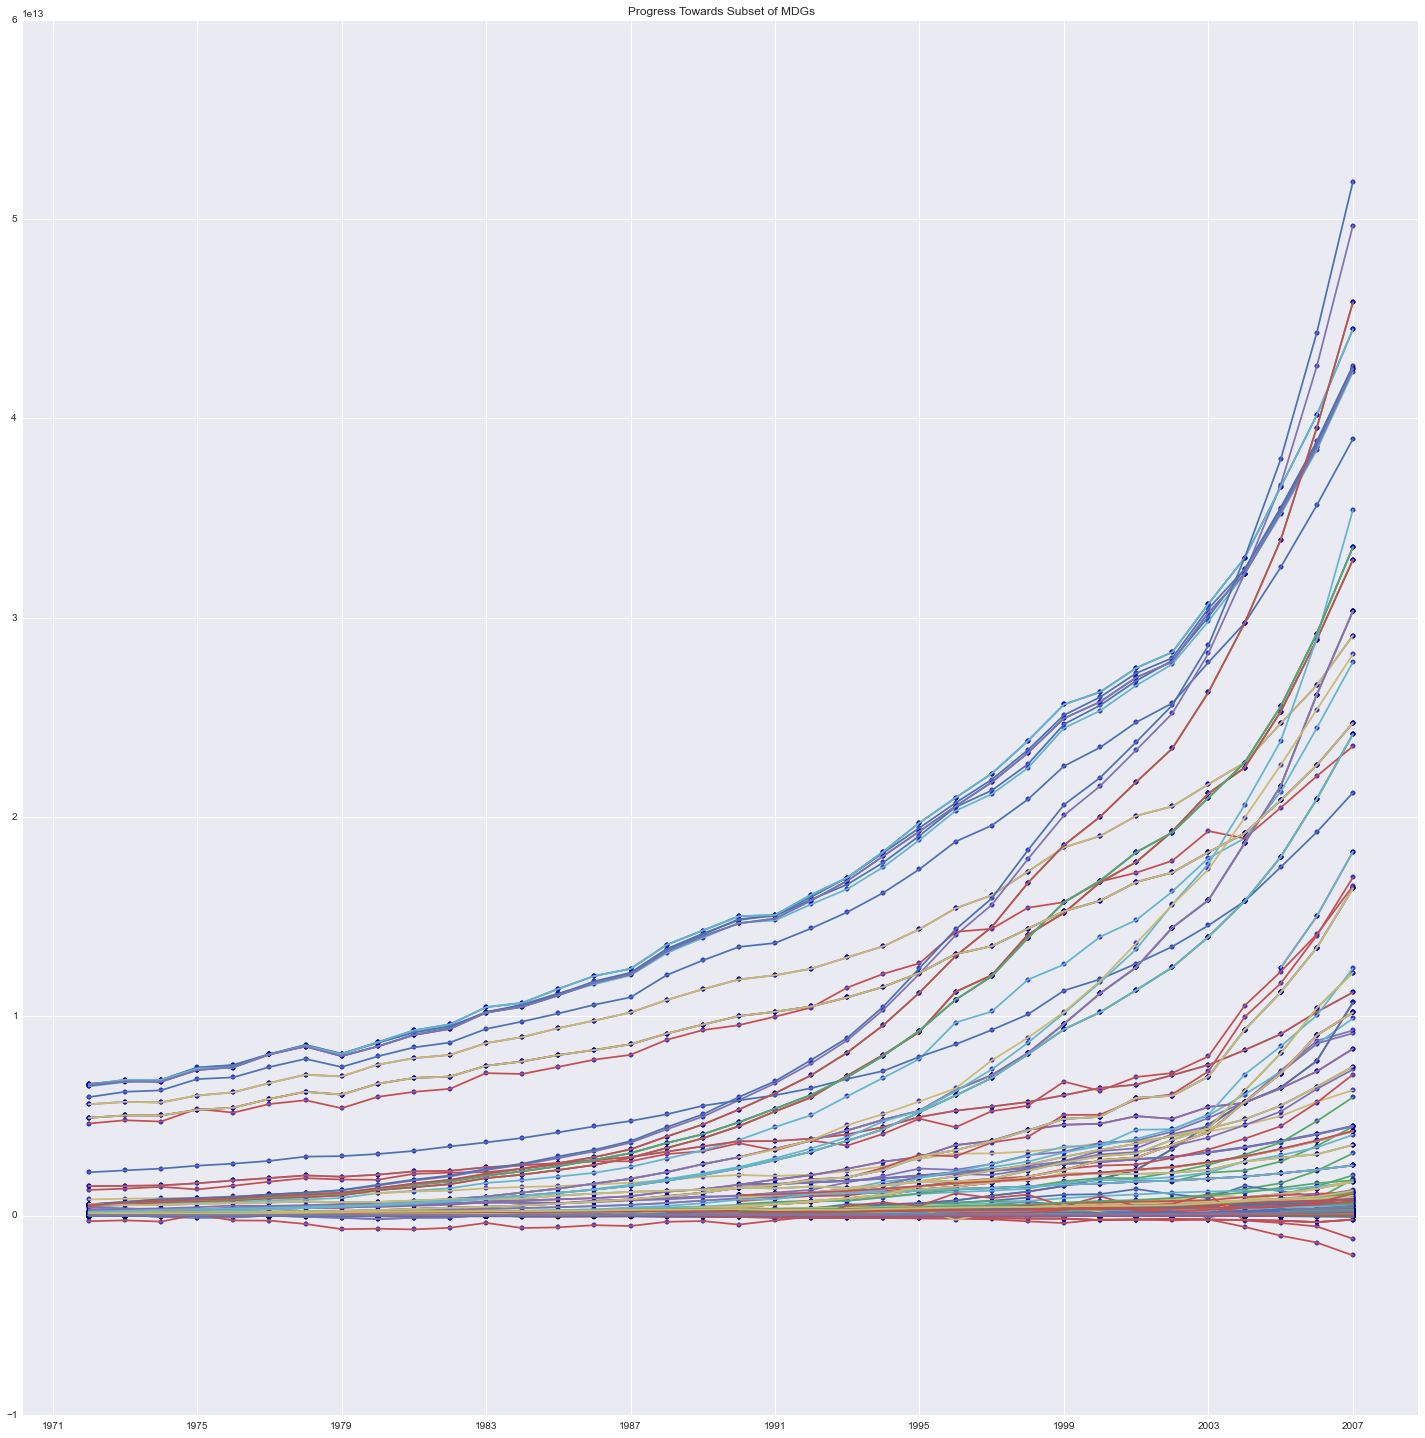

In [236]:
np.random.seed(100)
rand_rows = np.random.choice(indianr.index.values, size=1240)

def plot_rows(data, ids=None, linestyle="-", legend=True):
    # get some colors for the lines
    bmap = pplt.brewer2mpl.get_map('Set3','Qualitative', 10, True)
    #colors = bmap.mpl_colors
    
    if not None == ids:
        get_rows = lambda: enumerate(ids)
    else:
        get_rows = lambda: enumerate(data.index.values)
    
    for i, r in get_rows():
        # get the time series values
        time_data = data.loc[r]

        # create an x axis to plot along
        just_years = [y[:4] for y in data.columns]
        X = pd.DatetimeIndex(just_years)

        # get time series info for labeling
        country, descrip = india[["Country Name", "Series Name"]].loc[r]

        # plot the series
        plt.plot(X, time_data, 
                 label="{} - {}".format(country, descrip), ls=linestyle)
        plt.scatter(X, time_data, alpha=0.8)

#     if legend:
#         plt.legend(loc=0)
    plt.title("Progress Towards Subset of MDGs")

plot_rows(indianr, ids=rand_rows)
plt.show()